In [2]:
# install dependencies
!pip install smdebug

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 270 kB 7.8 MB/s            
     |████████████████████████████████| 83 kB 166 kB/s             


In [3]:
hyperparameters = {
    "batch_size": 2048,
    "gpu": True,
    "epoch": 2,
    "model": "resnet50",
}

In [4]:
from sagemaker.debugger import Rule, ProfilerRule, rule_configs

rules = [ Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization())
        ]

In [5]:
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile

#TODO: Can you create the profiler and debugger configs
profiler_config = ProfilerConfig(system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10))
debugger_config = DebuggerHookConfig(hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"})

In [6]:
import sagemaker
from sagemaker.pytorch import PyTorch

estimator = PyTorch(
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    source_dir="scripts",
    entry_point="pytorch_cifar_profiling.py",
    framework_version="1.8",
    py_version="py36",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules,
)

In [7]:
estimator.fit(wait=True)

2021-11-30 22:44:27 Starting - Starting the training job...LossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
...
2021-11-30 22:45:19 Starting - Launching requested ML instances.........
2021-11-30 22:46:58 Starting - Preparing the instances for training.........
2021-11-30 22:48:19 Downloading - Downloading input data...
2021-11-30 22:48:59 Training - Downloading the training image......................bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2021-11-30 22:52:34,639 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2021-11-30 22:52:34,661 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2021-11-30 22:52:37,684 sagemaker_pytorch_container.training INFO     Invoking user training script.
2021

In [8]:
import boto3

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

Training jobname: pytorch-training-2021-11-30-22-44-26-770
Region: us-east-1


In [9]:
from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

[2021-11-30 23:10:58.066 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:372 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2021-11-30 23:10:58.078 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:372 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-678049007427/pytorch-training-2021-11-30-22-44-26-770/debug-output


In [10]:
# TODO: Can you print the names of all the tensors that were tracked
print(trial.tensor_names())
# TODO: Can you print the number of datapoints for one of those tensors
# for both train and eval mode
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

[2021-11-30 23:11:05.095 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:372 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2021-11-30 23:11:06.128 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:372 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_bn1.bias', 'gradient/ResNet_bn1.weight', 'gradient/ResNet_conv1.weight', 'gradient/ResNet_fc.bias', 'gradient/ResNet_fc.weight', 'gradient/ResNet_layer1.0.bn1.bias', 'gradient/ResNet_layer1.0.bn1.weight', 'gradient/ResNet_layer1.0.bn2.bias', 'gradient/ResNet_layer1.0.bn2.weight', 'gradient/ResNet_layer1.0.bn3.bias', 'gradient/ResNet_layer1.0.bn3.weight', 'gradient/ResNet_layer1.0.conv1.weight', 'gradient/ResNet_layer1.0.conv2.weight', 'gradient/ResNet_layer1.0.conv3.weight', 'gradient/ResNet_layer1.0.downsample.0.weight', 'gradient/ResNet_layer1.0.downsample.1.bias', 'gradient/ResNet_layer1.0.downsample.1.weight', 'gradient/ResNet_layer1.1.bn1.bias', 'gradie

In [11]:
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

ProfilerConfig:{'S3OutputPath': 's3://sagemaker-us-east-1-678049007427/', 'ProfilingIntervalInMilliseconds': 500, 'ProfilingParameters': {'DataloaderProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "MetricsRegex": ".*", }', 'DetailedProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'FileOpenFailThreshold': '50', 'HorovodProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }', 'LocalPath': '/opt/ml/output/profiler', 'PythonProfilingConfig': '{"StartStep": 0, "NumSteps": 10, "ProfilerName": "cprofile", "cProfileTimer": "total_time", }', 'RotateFileCloseIntervalInSeconds': '60', 'RotateMaxFileSizeInBytes': '10485760', 'SMDataParallelProfilingConfig': '{"StartStep": 0, "NumSteps": 10, }'}}
s3 path:s3://sagemaker-us-east-1-678049007427/pytorch-training-2021-11-30-22-44-26-770/profiler-output


Profiler data from system is available


In [12]:
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2021-11-30 23:11:41.986 datascience-1-0-ml-t3-medium-1abf3407f667f989be9d86559395:372 INFO metrics_reader_base.py:134] Getting 20 event files
select events:['total']
select dimensions:['CPU', 'GPU']
filtered_events:{'total'}
filtered_dimensions:{'CPUUtilization-nodeid:algo-1', 'GPUMemoryUtilization-nodeid:algo-1', 'GPUUtilization-nodeid:algo-1'}


In [13]:
rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"You will find the profiler report in {rule_output_path}")

You will find the profiler report in s3://sagemaker-us-east-1-678049007427/pytorch-training-2021-11-30-22-44-26-770/rule-output


In [14]:
! aws s3 ls {rule_output_path} --recursive

2021-11-30 23:07:44     413231 pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-report.html
2021-11-30 23:07:44     268833 pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2021-11-30 23:07:39        530 pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2021-11-30 23:07:39      36396 pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2021-11-30 23:07:39       1913 pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2021-11-30 23:07:39        130 pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2021-11-30 23:07:39      14926 pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-re

In [15]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-678049007427/pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json to ProfilerReport/profiler-output/profiler-reports/BatchSize.json
download: s3://sagemaker-us-east-1-678049007427/pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-678049007427/pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json to ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
download: s3://sagemaker-us-east-1-678049007427/pytorch-training-2021-11-30-22-44-26-770/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-678049007427/pytorch-training

In [16]:
import os

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

In [ ]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

In [20]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode=mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode=mode))
    return steps, vals

In [18]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode=ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode=ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize=(10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1,) = host.plot(steps_train, vals_train, label=tensor_name)
    print("completed TRAIN plot")
    (p2,) = par.plot(steps_eval, vals_eval, label="val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


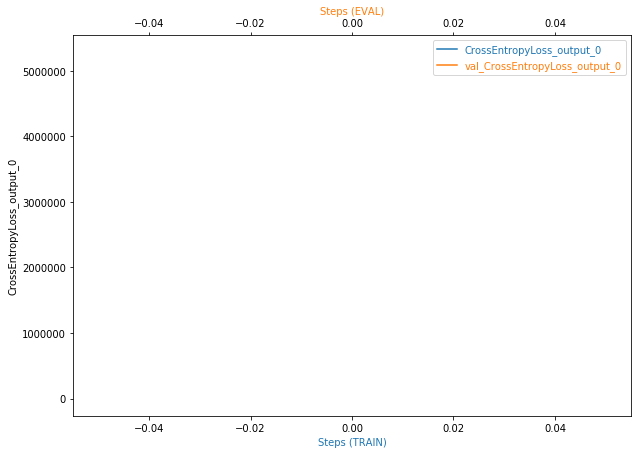

In [21]:
plot_tensor(trial, 'CrossEntropyLoss_output_0')